In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from numba import jit, prange

In [2]:
data =  yf.download(
            tickers = 'EURUSD=X',
            period = '2y',
            interval = "1d",
            group_by = 'ticker',
            auto_adjust = True,
            prepost = False,
            threads = True,
            proxy = None
        )

[*********************100%***********************]  1 of 1 completed


In [3]:
def fixed_interval(data, period=2, min_change=0.005):
  data.loc[:,'buy'] = False
  data.loc[:,'sell'] = False
  data.loc[:,'hold'] = False
  data.loc[:,'future'] = data['Close'].shift(-period)
  data.loc[:,'buy']  = (data['future']  / (data['Close'] ) )-1 > min_change
  data.loc[:,'sell']  = (data['Close'] / (data['future'] ))-1 > min_change
  data.loc[:,'hold']  = data.apply(lambda x: True if x['buy'] == False and x['sell'] ==False else False, axis=1)
  return data


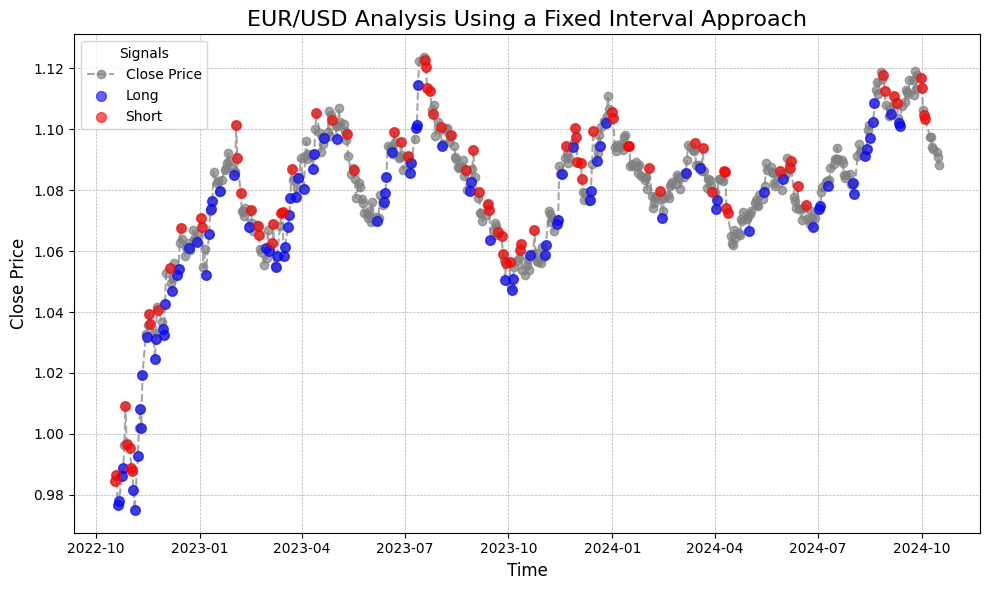

In [4]:
labelled_data = fixed_interval(data)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Close' prices
ax.plot(labelled_data.index, labelled_data['Close'], color='gray', linestyle='--', marker='o', label='Close Price', alpha=0.7)

# Colorblind-friendly colors: Buy = teal, Sell = orange, Hold = purple
ax.scatter(labelled_data.index[labelled_data['buy']], labelled_data['Close'][labelled_data['buy']], color='blue', label='Long', s=50, alpha=0.6, zorder=5)
ax.scatter(labelled_data.index[labelled_data['sell']], labelled_data['Close'][labelled_data['sell']], color='red', label='Short', s=50, alpha=0.6, zorder=5)

# Adding labels and title
ax.set_title('EUR/USD Analysis Using a Fixed Interval Approach', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close Price', fontsize=12)

# Adding a legend
ax.legend(title="Signals", loc="upper left", fontsize=10)

# Adding grid for better visibility
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Make the plot look professional
plt.tight_layout()
plt.show()

In [5]:
gbpusd =  yf.download(
            tickers = 'GBPUSD=X',
            period = '2y',
            interval = "1d",
            group_by = 'ticker',
            auto_adjust = True,
            prepost = False,
            threads = True,
            proxy = None
        )
eurgbp =  yf.download(
            tickers = 'EURGBP=X',
            period = '2y',
            interval = "1d",
            group_by = 'ticker',
            auto_adjust = True,
            prepost = False,
            threads = True,
            proxy = None
        )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
data.loc[:, 'benchmark_price'] = gbpusd['Close']*eurgbp['Close']
data.loc[:, 'benchmark'] = data['benchmark_price'].diff()
data.loc[:, 'asset_class_growth'] = data['Close'].diff()
data.loc[:, 'benchmark_growth'] = data['benchmark_price'].diff()
data.loc[:, 'diff'] = data['asset_class_growth']-data['benchmark_growth']
data[['benchmark_growth','asset_class_growth', 'diff']].describe()

,benchmark_growth,asset_class_growth,diff
count,520.000000,520.000000,5.200000e+02
mean,0.000200,0.000200,-1.920977e-07
std,0.004827,0.004815,5.862664e-04
min,-0.014726,-0.014430,-6.234525e-03
25%,-0.002789,-0.002741,-1.009260e-04
50%,0.000024,-0.000093,-3.369776e-06
75%,0.003038,0.003080,9.927127e-05
max,0.017917,0.017918,6.193006e-03


In [7]:
def excess_over_benchmark_mean_reverting(data, min_change=0.0001):
  data[['buy', 'sell', 'hold']]= False
  data.loc[:, 'growth'] = data['Close'].diff()
  data.loc[:,'buy']  = data['growth'] - data['benchmark']  < min_change
  data.loc[:,'sell']  = data['growth'] - data['benchmark']  > min_change
  data.loc[:,'hold']  = data.apply(lambda x: True if x['buy'] == False and x['sell'] ==False else False, axis=1)
  return data


In [8]:
def excess_over_benchmark_condifence(data, min_change=0.0001):
  data.loc[:,'buy'] = False
  data.loc[:,'sell'] = False
  data.loc[:,'hold'] = False
  data.loc[:, 'growth'] = data['Close'].diff()
  data.loc[:,'buy']  = data['growth'] - data['benchmark']  > min_change
  data.loc[:,'sell']  = data['growth'] - data['benchmark']  < min_change
  data.loc[:,'hold']  = data.apply(lambda x: True if x['buy'] == False and x['sell'] ==False else False, axis=1)
  return data


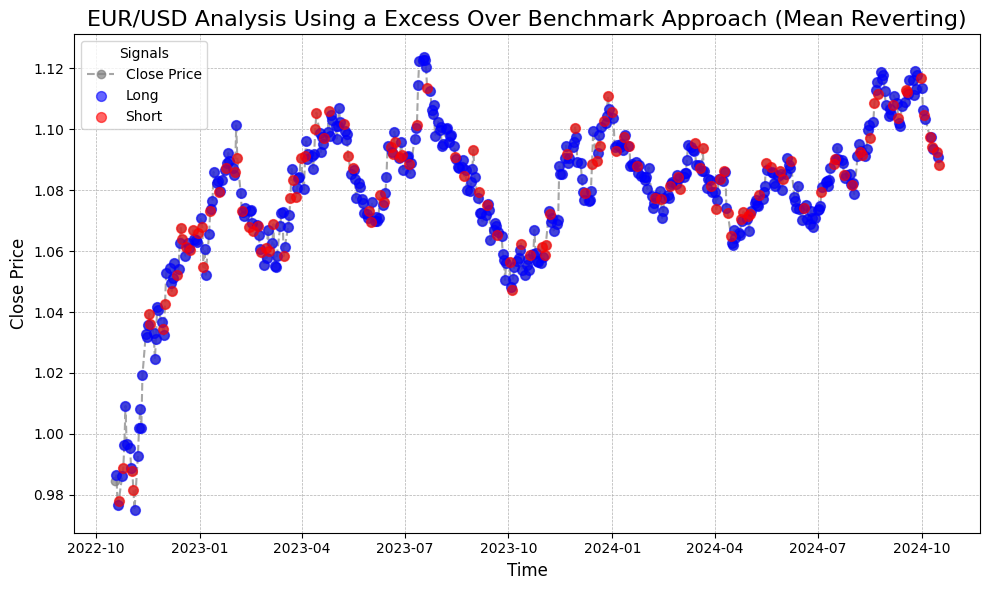

In [9]:
labelled_data = excess_over_benchmark_mean_reverting(data, min_change=0.0001)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Close' prices
ax.plot(labelled_data.index, labelled_data['Close'], color='gray', linestyle='--', marker='o', label='Close Price', alpha=0.7)

# Colorblind-friendly colors: Buy = teal, Sell = orange, Hold = purple
ax.scatter(labelled_data.index[labelled_data['buy']], labelled_data['Close'][labelled_data['buy']], color='blue', label='Long', s=50, alpha=0.6, zorder=5)
ax.scatter(labelled_data.index[labelled_data['sell']], labelled_data['Close'][labelled_data['sell']], color='red', label='Short', s=50, alpha=0.6, zorder=5)

# Adding labels and title
ax.set_title('EUR/USD Analysis Using a Excess Over Benchmark Approach (Mean Reverting)', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close Price', fontsize=12)

# Adding a legend
ax.legend(title="Signals", loc="upper left", fontsize=10)

# Adding grid for better visibility
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Make the plot look professional
plt.tight_layout()
plt.show()

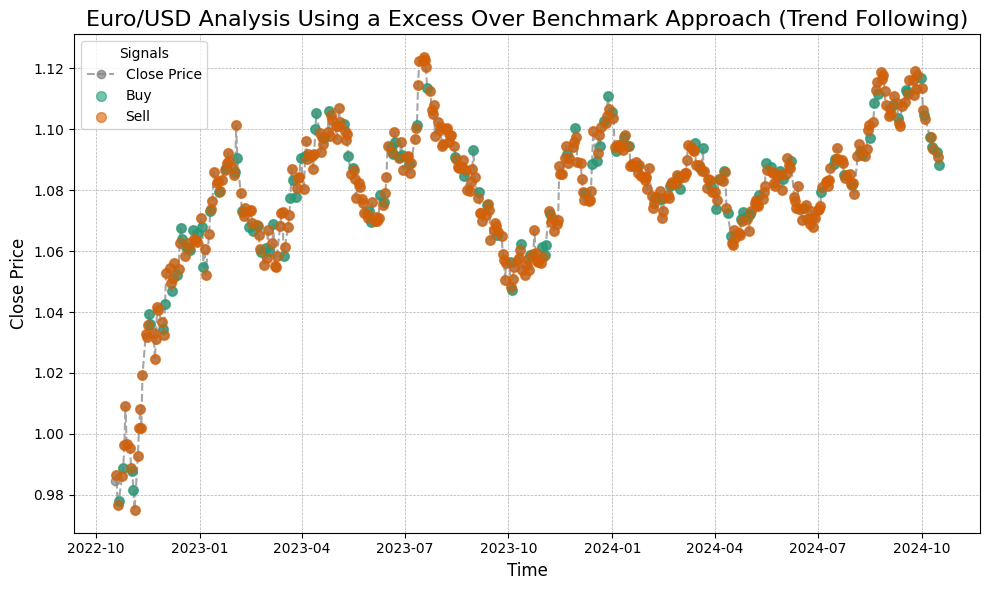

In [10]:
labelled_data = excess_over_benchmark_condifence(data, min_change=0.0001)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Close' prices
ax.plot(labelled_data.index, labelled_data['Close'], color='gray', linestyle='--', marker='o', label='Close Price', alpha=0.7)

# Colorblind-friendly colors: Buy = teal, Sell = orange, Hold = purple
ax.scatter(labelled_data.index[labelled_data['buy']], labelled_data['Close'][labelled_data['buy']], color='#1b9e77', label='Buy', s=50, alpha=0.6, zorder=5)
ax.scatter(labelled_data.index[labelled_data['sell']], labelled_data['Close'][labelled_data['sell']], color='#d95f02', label='Sell', s=50, alpha=0.6, zorder=5)

# Adding labels and title
ax.set_title('Euro/USD Analysis Using a Excess Over Benchmark Approach (Trend Following)', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close Price', fontsize=12)

# Adding a legend
ax.legend(title="Signals", loc="upper left", fontsize=10)

# Adding grid for better visibility
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Make the plot look professional
plt.tight_layout()
plt.show()

In [11]:
labelled_data[labelled_data['benchmark']==labelled_data['benchmark'].max()]

,Open,High,Low,Close,Volume,buy,sell,hold,future,benchmark_price,benchmark,asset_class_growth,benchmark_growth,diff,growth
Date,,,,,,,,,,,,,,,
2022-11-07,0.992881,1.0005,0.991945,0.992881,0,False,True,False,1.008085,0.992804,0.017917,0.017918,0.017917,7.224263e-07,0.017918


In [12]:
(1.00026)**(365)

1.0995353320384365

In [13]:
def expected_return(data, commission=0.00001, discount_rate=0.00026, investment_horizon=10):
  ##only considers gains/loss. not the capital
  data[['buy', 'sell', 'hold']]= False
  indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=investment_horizon)
  present_values = [1/(1+discount_rate)**(i+1) for i in range(investment_horizon)]
  data.loc[:,'diff']= (data['Close'].diff().fillna(0))
  data.loc[:,'present_value_long'] = data['diff'].rolling(window=indexer, min_periods=investment_horizon).apply(lambda x: sum(x*present_values)) - data['Close'] + (data['Close']/(1+discount_rate)**(investment_horizon))-commission
  data.loc[:,'present_value_short'] = data['diff'].rolling(window=indexer, min_periods=investment_horizon).apply(lambda x: sum(-x*present_values)) + data['Close'] - (data['Close']/(1+discount_rate)**(investment_horizon))-commission
  data.loc[data['present_value_long']>0, 'buy']= True
  data.loc[data['present_value_short']>0, 'sell']= True
  data.loc[:,'hold']  = data.apply(lambda x: False if x['buy'] == True or x['sell'] == True else True, axis=1)
  data[['buy', 'sell', 'hold']] = data[['buy', 'sell', 'hold']].fillna(False)
  return data

In [14]:
labelled_data = expected_return(data)
labelled_data

,Open,High,Low,Close,Volume,buy,sell,hold,future,benchmark_price,benchmark,asset_class_growth,benchmark_growth,diff,growth,present_value_long,present_value_short
Date,,,,,,,,,,,,,,,,,
2022-10-18,0.984640,0.987362,0.981460,0.984640,0,True,False,False,0.976648,0.984388,NaN,NaN,NaN,0.000000,NaN,0.008277,-0.008297
2022-10-19,0.986388,0.986699,0.976019,0.986388,0,True,False,False,0.977890,0.986285,0.001896,0.001748,0.001896,0.001748,0.001748,0.001423,-0.001443
2022-10-20,0.976648,0.984514,0.975553,0.976648,0,False,True,False,0.986009,0.976580,-0.009705,-0.009740,-0.009705,-0.009740,-0.009740,-0.001136,0.001116
2022-10-21,0.977890,0.985698,0.970732,0.977890,0,True,False,False,0.988650,0.977546,0.000966,0.001242,0.000966,0.001242,0.001242,0.002267,-0.002287
2022-10-24,0.986009,0.988963,0.980892,0.986009,0,False,True,False,0.996373,0.985887,0.008341,0.008119,0.008341,0.008119,0.008119,-0.005456,0.005436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-10,1.094331,1.095446,1.091405,1.094331,0,False,False,True,1.092538,1.094131,-0.003399,-0.003243,-0.003399,-0.003243,-0.003243,NaN,NaN
2024-10-11,1.093386,1.095422,1.092741,1.093386,0,False,False,True,1.090917,1.093316,-0.000815,-0.000945,-0.000815,-0.000945,-0.000945,NaN,NaN
2024-10-14,1.092538,1.093972,1.090572,1.092538,0,False,False,True,1.088412,1.092309,-0.001007,-0.000848,-0.001007,-0.000848,-0.000848,NaN,NaN


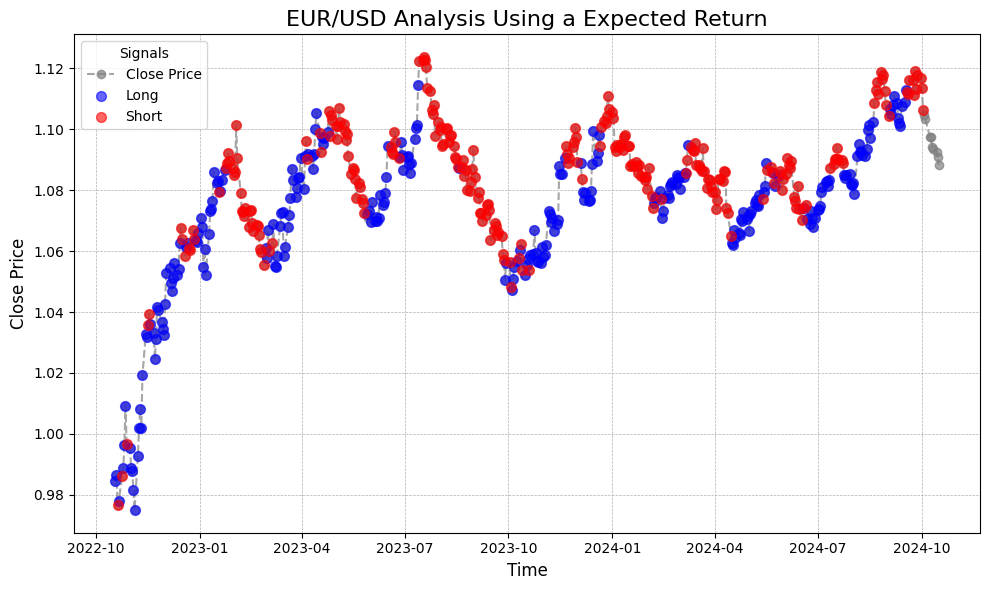

In [15]:
labelled_data = expected_return(data)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Close' prices
ax.plot(labelled_data.index, labelled_data['Close'], color='gray', linestyle='--', marker='o', label='Close Price', alpha=0.7)

# Colorblind-friendly colors: Buy = teal, Sell = orange, Hold = purple
ax.scatter(labelled_data.index[labelled_data['buy']], labelled_data['Close'][labelled_data['buy']], color='blue', label='Long', s=50, alpha=0.6, zorder=5)
ax.scatter(labelled_data.index[labelled_data['sell']], labelled_data['Close'][labelled_data['sell']], color='red', label='Short', s=50, alpha=0.6, zorder=5)

# Adding labels and title
ax.set_title('EUR/USD Analysis Using a Expected Return', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close Price', fontsize=12)

# Adding a legend
ax.legend(title="Signals", loc="upper left", fontsize=10)

# Adding grid for better visibility
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Make the plot look professional
plt.tight_layout()
plt.show()

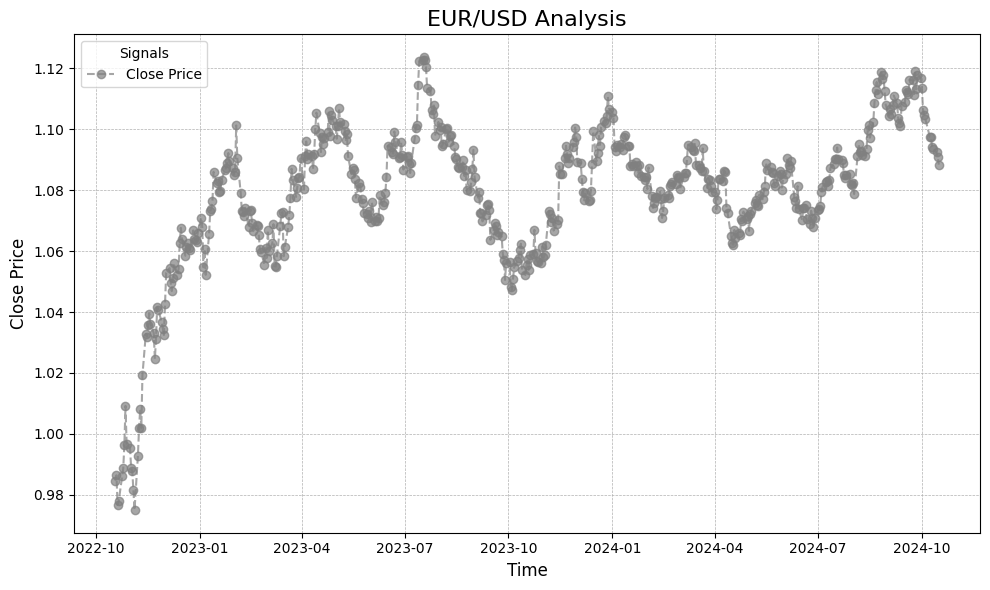

In [16]:
labelled_data = expected_return(data)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Close' prices
ax.plot(labelled_data.index, labelled_data['Close'], color='gray', linestyle='--', marker='o', label='Close Price', alpha=0.7)

# Adding labels and title
ax.set_title('EUR/USD Analysis', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close Price', fontsize=12)

# Adding a legend
ax.legend(title="Signals", loc="upper left", fontsize=10)

# Adding grid for better visibility
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Make the plot look professional
plt.tight_layout()
plt.show()

In [17]:
@jit(nopython=True,  cache=True)
def getTripleBarrierLabels(all_prices, max_length, target_gain):
    target_gain_ref = round(target_gain,7)
    transaction_cost=0.00001 #pct
    positions = []
    for i in range(len(all_prices)):
        position=0 #(0 neutral, + buy , - short )
        current_position = all_prices[i] # get the current dataframe

        max_range = min(len(all_prices[i:]), max_length+1)
        for j in range(max_range):
            b_current_return = round(all_prices[i+j] / (current_position * (1+transaction_cost)) - 1,7)
            s_current_return = round((current_position * (1-transaction_cost)) / all_prices[i+j] - 1,7)
            if b_current_return>=target_gain_ref:
                position = i+j
                # position = j
                break
            elif s_current_return>=target_gain_ref:
                position = -(i+j)
                # position = -j
                break

        positions.append(position)

    return positions

In [18]:
def triple_barrier(data, investment_horizon=10, target_gain=0.01):
    data.loc[:,'uniqueness_identifier'] =  getTripleBarrierLabels(all_prices= data['Close'].values, max_length=investment_horizon, target_gain=target_gain) #6 hours max holding period

    data.loc[:,'buy'] = False
    data.loc[:,'sell'] = False
    data.loc[:,'hold'] = False
    data.loc[:,'hold_period'] = 0

    data['uniqueness_identifier'] = data['uniqueness_identifier'].fillna(0)

    data.loc[data['uniqueness_identifier']>0,'buy'] = True
    data.loc[data['uniqueness_identifier']<0,'sell'] = True
    data.loc[(data['uniqueness_identifier']==0) | (data['uniqueness_identifier'].isna()) ,'hold'] = True


    return data


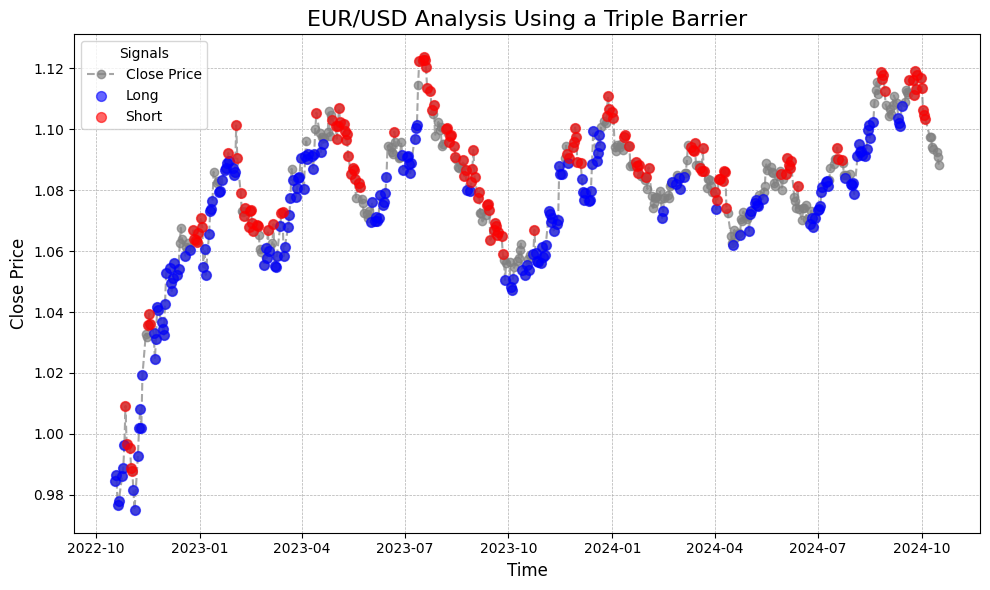

In [19]:
labelled_data = triple_barrier(data)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Close' prices
ax.plot(labelled_data.index, labelled_data['Close'], color='gray', linestyle='--', marker='o', label='Close Price', alpha=0.7)

# Colorblind-friendly colors: Buy = teal, Sell = orange, Hold = purple
ax.scatter(labelled_data.index[labelled_data['buy']], labelled_data['Close'][labelled_data['buy']], color='blue', label='Long', s=50, alpha=0.6, zorder=5)
ax.scatter(labelled_data.index[labelled_data['sell']], labelled_data['Close'][labelled_data['sell']], color='red', label='Short', s=50, alpha=0.6, zorder=5)

# Adding labels and title
ax.set_title('EUR/USD Analysis Using a Triple Barrier', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close Price', fontsize=12)

# Adding a legend
ax.legend(title="Signals", loc="upper left", fontsize=10)

# Adding grid for better visibility
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Make the plot look professional
plt.tight_layout()
plt.show()

In [20]:
@jit(nopython=True, cache=True)
def ols_regression(y, X):
    n, k = X.shape
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    e = y - X @ beta
    RSS = np.sum(e**2)
    dof = n - k
    RSE = np.sqrt(RSS / dof)
    cov_beta = np.linalg.inv(X.T @ X) * RSE**2
    se_beta = np.sqrt(np.diag(cov_beta))
    t_values = beta / se_beta

    return beta, se_beta, t_values

@jit(nopython=True, cache=True)
def tValLinR(close):
    n = close.shape[0]
    X = np.column_stack((np.ones(n), np.arange(n)))
    y = close.astype(np.float64)  # Convert to native type for Numba compatibility

    # Perform OLS regression
    beta, se_beta, t_values = ols_regression(y, X)

    return t_values[1]  # Return t-value for the second coefficient (excluding intercept)


@jit(nopython=True, cache=True)
def getBinsFromTrend(close,span,threshold):
    '''
    Derive labels from the sign of t-value of linear trend
    Output includes:
    - t1: End time for the identified trend
    - tVal: t-value associated with the estimated trend coefficient - bin: Sign of the trend
    '''
    max_length = len(close)
    hrzns=prange(*span)
    out= np.zeros(max_length)
    t_values= np.zeros(max_length)
    for idx in prange(max_length):
        if idx+max(hrzns)>max_length:continue
        max_tvalue = -np.inf
        selected_tvalue=0
        for hrzn in hrzns:
            end_idx = hrzn+idx
            t_value=tValLinR(close[idx:end_idx])
            abs_tvalue =  abs(t_value)
            if np.isinf(t_value) or np.isnan(t_value):
                t_value=0
            max_tvalue = max(abs_tvalue, max_tvalue)
            if max_tvalue ==abs_tvalue and abs_tvalue>=threshold:
                selected_tvalue=end_idx*np.sign(t_value)
        out[idx] = selected_tvalue
        t_values[idx] = t_value
    return out, t_values


In [21]:
def trend_scanning(data, span=10, threshold=0.00001):
  if span<=5:
    print('span must be more than 5')
  else:
      span =  (min(span,4),span,1)
      out, t_values = getBinsFromTrend(data['Close'].values, span=span, threshold=threshold)
      data.loc[:, ['uniqueness_identifier', 'tvlues']] = np.column_stack((out, t_values))

      data.loc[:,'buy'] = False
      data.loc[:,'sell'] = False
      data.loc[:,'hold'] = False

      data['uniqueness_identifier'] = data['uniqueness_identifier'].fillna(0)

      data.loc[data['uniqueness_identifier']>0,'buy'] = True
      data.loc[data['uniqueness_identifier']<0,'sell'] = True
      data.loc[(data['uniqueness_identifier']==0) | (data['uniqueness_identifier'].isna()) ,'hold'] = True

      return data

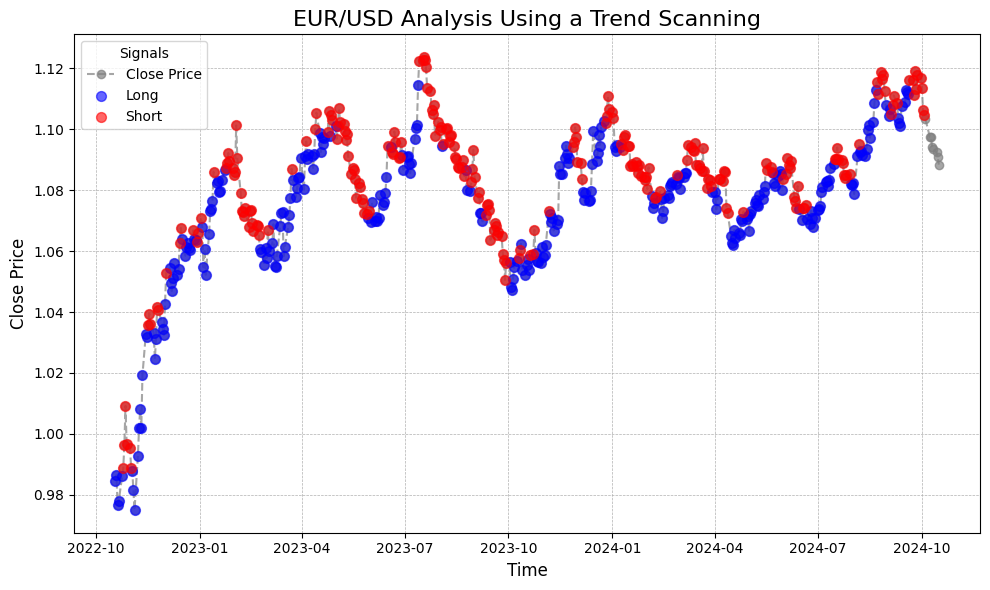

In [22]:
labelled_data = trend_scanning(data)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Close' prices
ax.plot(labelled_data.index, labelled_data['Close'], color='gray', linestyle='--', marker='o', label='Close Price', alpha=0.7)

# Colorblind-friendly colors: Buy = teal, Sell = orange, Hold = purple
ax.scatter(labelled_data.index[labelled_data['buy']], labelled_data['Close'][labelled_data['buy']], color='blue', label='Long', s=50, alpha=0.6, zorder=5)
ax.scatter(labelled_data.index[labelled_data['sell']], labelled_data['Close'][labelled_data['sell']], color='red', label='Short', s=50, alpha=0.6, zorder=5)

# Adding labels and title
ax.set_title('EUR/USD Analysis Using a Trend Scanning', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Close Price', fontsize=12)

# Adding a legend
ax.legend(title="Signals", loc="upper left", fontsize=10)

# Adding grid for better visibility
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Make the plot look professional
plt.tight_layout()
plt.show()